# Machine Learning 1 - Nearest Neighbors and Decision Trees

## Lab objectives

* Classification with decision trees and random forests.
* Cross-validation and evaluation.

In [1]:
from lab_tools import CIFAR10

dataset = CIFAR10('../data/CIFAR10/CIFAR10/')

Pre-loading training data
Pre-loading test data


# 1. Nearest Neighbor

The following example uses the Nearest Neighbor algorithm on the Histogram of Gradient decriptors in the dataset.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier(n_neighbors=1)
kn_clf.fit( dataset.train['hog'], dataset.train['labels'] )

KNeighborsClassifier(n_neighbors=1)

*Descriptive Performance of a Classifier*:
It tells you how well the classifier explains the training data. It’s about fitting: how well the model captures patterns in the data it has already seen.\
Typical metrics:
- Accuracy on the training set
- Confusion matrix on the training set
- Classification report (precision, recall, F1-score) on training data
> Example: if you train a logistic regression model, then check accuracy on the training set, you’re measuring descriptive performance.

*Predictive Performance of a Classifier*:
It measures how well the classifier generalizes to new, unseen data. It's about generalization: how good the model will be at predicting unknown examples.\
Typical metrics:
- Accuracy on the test set (or validation set)
- ROC AUC score on test data (for thresholded classifiers)
- Cross-validation scores
>Example: if you split your dataset into training and test parts, and then check how the model performs on the test set, you’re measuring predictive performance.

* What is the **descriptive performance** of this classifier ?
* Modify the code to estimate the **predictive performance**.
* Use cross-validation to find the best hyper-parameters for this method.

Train accuracy:  1.0


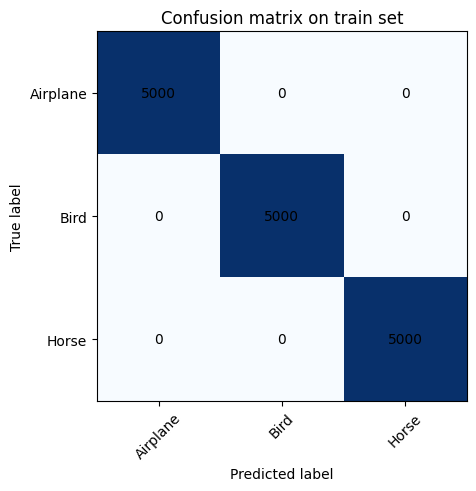

In [3]:
# descriptive performance
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

print("Train accuracy: ", kn_clf.score( dataset.train['hog'], dataset.train['labels'] ))

#confusion matrix on train set
cm = confusion_matrix(dataset.train['labels'], kn_clf.predict(dataset.train['hog']))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix on train set')
plt.xticks(range(3), dataset.labels, rotation=45)
plt.yticks(range(3), dataset.labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Write the numbers directly into the cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()


By definition of the nearest neighbour, it's descriptive performance is 100% on the training set. Because it fits the training set perfectly.

Test accuracy:  0.694
Cross-validation accuracy (only on training set):  0.6884666666666667


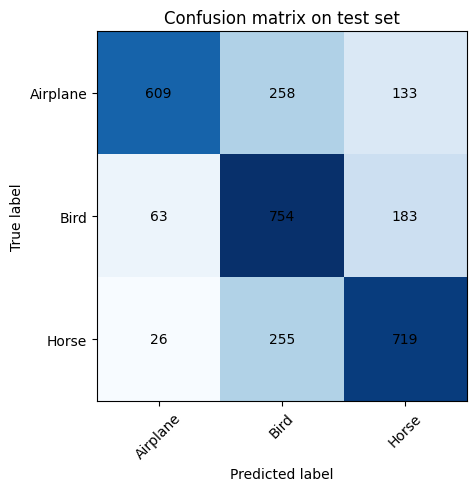

              precision    recall  f1-score   support

    Airplane       0.87      0.61      0.72      1000
        Bird       0.60      0.75      0.67      1000
       Horse       0.69      0.72      0.71      1000

    accuracy                           0.69      3000
   macro avg       0.72      0.69      0.70      3000
weighted avg       0.72      0.69      0.70      3000



In [4]:
# predictive performance
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

print("Test accuracy: ", kn_clf.score( dataset.test['hog'], dataset.test['labels'] ))

#cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(kn_clf, dataset.train['hog'], dataset.train['labels'], cv=cv)
print("Cross-validation accuracy (only on training set): ", scores.mean())

#confusion matrix on test set
cm = confusion_matrix( dataset.test['labels'], kn_clf.predict( dataset.test['hog'] ) )
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix on test set')
plt.xticks(range(3), dataset.labels, rotation=45)
plt.yticks(range(3), dataset.labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Write the numbers directly into the cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()

# classification report
print(classification_report( dataset.test['labels'], kn_clf.predict( dataset.test['hog'] ), target_names=dataset.labels ) )

The predictive performance is not so good, it looks like it's overfitting the training set.

In [5]:
# Find best parameters of KNN
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}
kn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(kn_clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(dataset.train['hog'], dataset.train['labels'])
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
# Test the best parameters on the test set
best_kn_clf = grid_search.best_estimator_
print("Test accuracy with best parameters: ", best_kn_clf.score(dataset.test['hog'], dataset.test['labels']))
#confusion matrix on test set with best parameters
cm = confusion_matrix(dataset.test['labels'], best_kn_clf.predict(dataset.test['hog']))
print(cm)

Best parameters:  {'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation score:  0.7111333333333334
Test accuracy with best parameters:  0.722
[[618 291  91]
 [ 60 811 129]
 [ 13 250 737]]


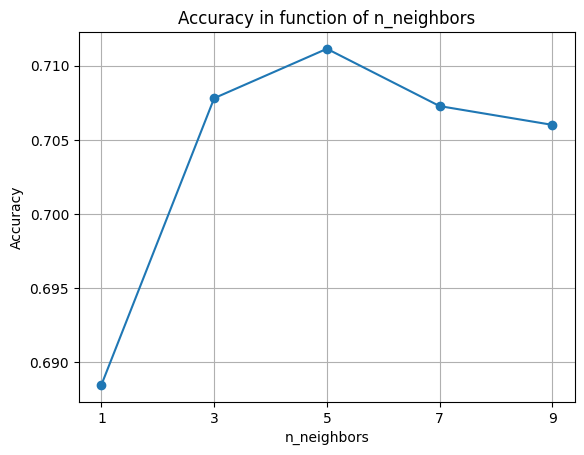

[0.6884666666666667,
 0.7078,
 0.7111333333333334,
 0.7072666666666666,
 0.7060000000000001]

In [6]:
from lab_tools import evaluate_parameter

evaluate_parameter(
    model_class=KNeighborsClassifier,
    param_name='n_neighbors',
    param_range=range(1, 11, 2),
    X_train=dataset.train['hog'],
    y_train=dataset.train['labels'],
    fixed_params={'weights': 'uniform'}
)

## 2. Decision Trees

[Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tree) classify the data by splitting the feature space according to simple, single-feature rules. Scikit-learn uses the [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29) algorithm for [its implementation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) of the classifier. 

* **Create a simple Decision Tree classifier** using scikit-learn and train it on the HoG training set.
* Use cross-validation to find the best hyper-parameters for this method.

Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.56133333 0.55733333 0.579      0.58633333 0.55666667]
Cross-validation mean accuracy :  0.5681333333333333
Training set accuracy (cheating) :  1.0
Confusion Matrix (on training set) :
 [[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]
Predictive Performance Metrics
Test set accuracy :  0.5706666666666667
Confusion Matrix (on test set) :
 [[608 220 172]
 [201 527 272]
 [150 273 577]]
Classification report :
               precision    recall  f1-score   support

           0      0.634     0.608     0.621      1000
           1      0.517     0.527     0.522      1000
           2      0.565     0.577     0.571      1000

    accuracy                          0.571      3000
   macro avg      0.572     0.571     0.571      3000
weighted avg      0.572     0.571     0.571      3000

Learning Curve :


(0.5681333333333333,
 0.5706666666666667,
 array([[608, 220, 172],
        [201, 527, 272],
        [150, 273, 577]]))

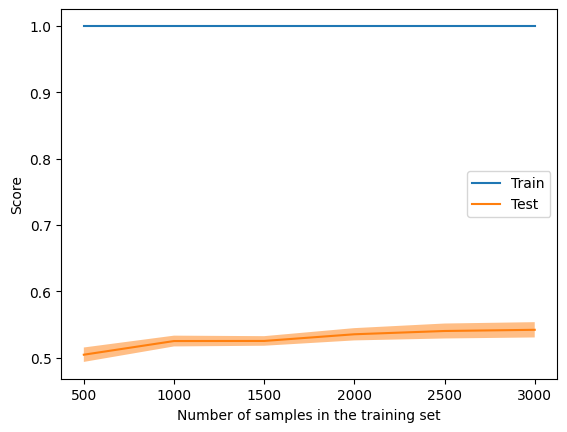

In [7]:
from sklearn.tree import DecisionTreeClassifier
from lab_tools import ML_pipeline

tree_clf = DecisionTreeClassifier()
ML_pipeline(tree_clf, dataset.train['hog'], dataset.train['labels'], dataset.test['hog'], dataset.test['labels'],True)

Searching best parameters...
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score:  0.5972
Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.57766667 0.59466667 0.61066667 0.59766667 0.593     ]
Cross-validation mean accuracy :  0.5947333333333333
Training set accuracy (cheating) :  0.7907333333333333
Confusion Matrix (on training set) :
 [[3959  753  288]
 [ 395 4037  568]
 [ 228  907 3865]]
Predictive Performance Metrics
Test set accuracy :  0.6013333333333334
Confusion Matrix (on test set) :
 [[590 263 147]
 [158 626 216]
 [118 294 588]]
Classification report :
               precision    recall  f1-score   support

           0      0.681     0.590     0.632      1000
           1      0.529     0.626     0.574      1000
           2      0.618     0.588     0.603      1000

    accuracy                          0.601      3000
   macro avg      0.610     0

(0.5947333333333333,
 0.6013333333333334,
 array([[590, 263, 147],
        [158, 626, 216],
        [118, 294, 588]]))

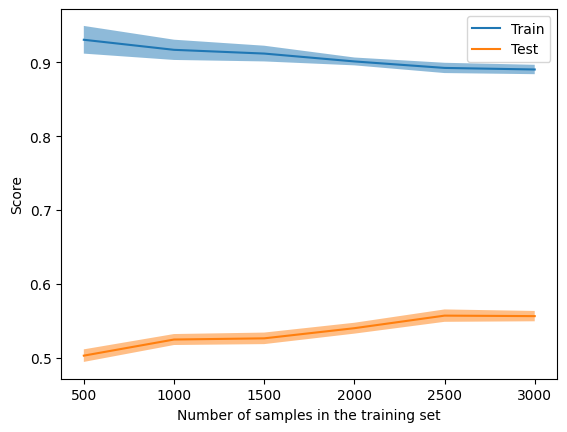

In [8]:
from lab_tools import find_best_hyperparameters
param_grid ={
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_params = find_best_hyperparameters(tree_clf, param_grid, dataset.train['hog'], dataset.train['labels'])
best_tree_model = DecisionTreeClassifier(**best_params)
ML_pipeline(best_tree_model, dataset.train['hog'], dataset.train['labels'], dataset.test['hog'], dataset.test['labels'],True)

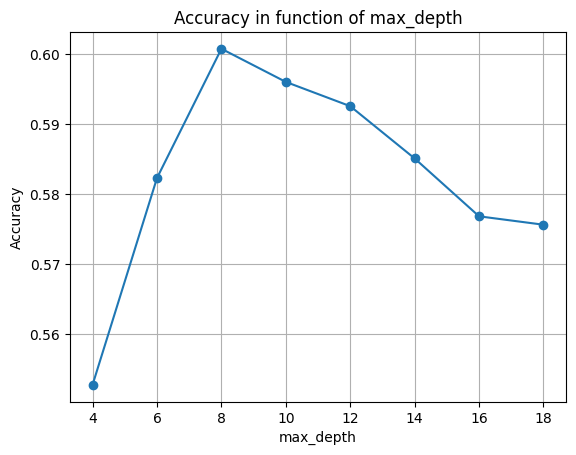

[0.5528,
 0.5823333333333334,
 0.6007999999999999,
 0.5960666666666666,
 0.5926,
 0.5851333333333334,
 0.5768666666666666,
 0.5756666666666667]

In [9]:
#analyze in depth the evolution of the hyper-parameter max_depth
from sklearn.tree import DecisionTreeClassifier
from lab_tools import evaluate_parameter

evaluate_parameter(
    model_class=DecisionTreeClassifier,
    param_name='max_depth',
    param_range=range(4, 20, 2),
    X_train=dataset.train['hog'],
    y_train=dataset.train['labels'],
    fixed_params={'min_samples_leaf': 2}
)


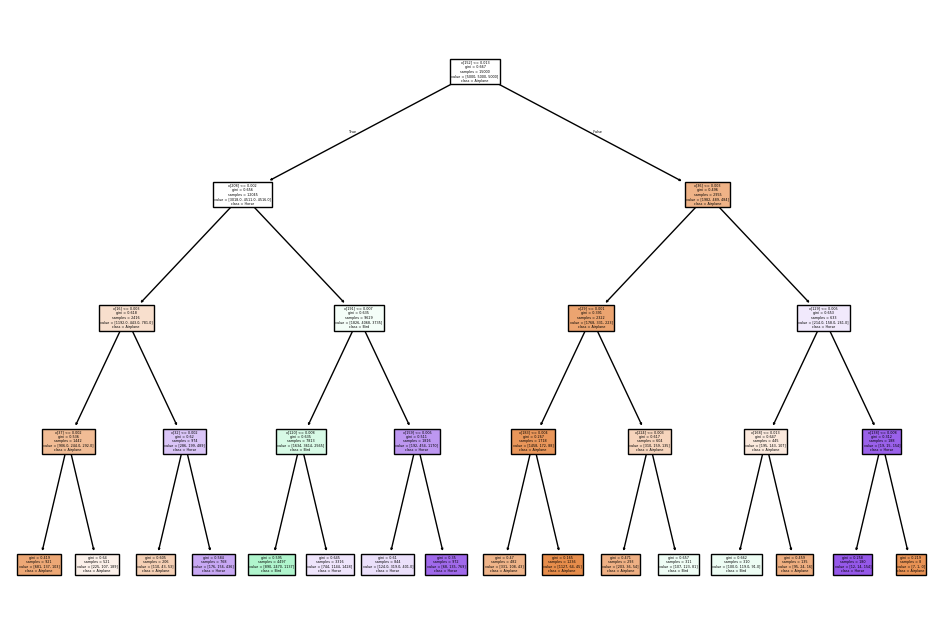

In [10]:
from sklearn.tree import plot_tree
tree_model = DecisionTreeClassifier(max_depth= 4, min_samples_leaf= 2, min_samples_split= 5)
tree_model.fit(dataset.train['hog'], dataset.train['labels'])

# plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, class_names=dataset.labels, filled=True)
plt.show()

## 3. Random Forests

[Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifiers use multiple decision trees trained on "weaker" datasets (less data and/or less features), averaging the results so as to reduce over-fitting.

* Use scikit-learn to **create a Random Forest classifier** on the CIFAR data. 
* Use cross-validation to find the best hyper-parameters for this method.

Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.737      0.761      0.76666667 0.759      0.76433333]
Cross-validation mean accuracy :  0.7576
Training set accuracy (cheating) :  1.0
Confusion Matrix (on training set) :
 [[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]
Predictive Performance Metrics
Test set accuracy :  0.7683333333333333
Confusion Matrix (on test set) :
 [[794 156  50]
 [124 728 148]
 [ 55 162 783]]
Classification report :
               precision    recall  f1-score   support

           0      0.816     0.794     0.805      1000
           1      0.696     0.728     0.712      1000
           2      0.798     0.783     0.791      1000

    accuracy                          0.768      3000
   macro avg      0.770     0.768     0.769      3000
weighted avg      0.770     0.768     0.769      3000

Learning Curve :


(0.7576,
 0.7683333333333333,
 array([[794, 156,  50],
        [124, 728, 148],
        [ 55, 162, 783]]))

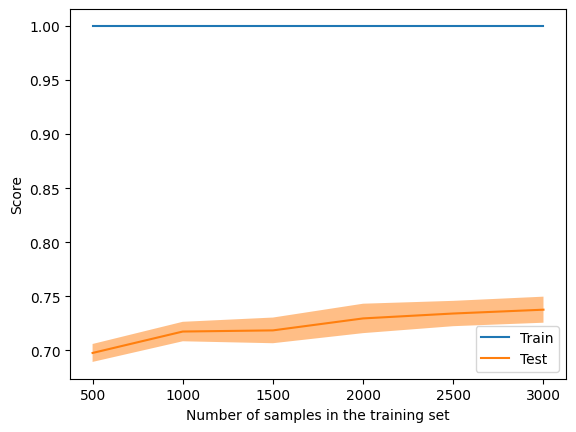

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ML_pipeline(rf_clf, dataset.train['hog'],
            dataset.train['labels'],
            dataset.test['hog'],
            dataset.test['labels'],
            True)


Searching best parameters...


Best parameters:  {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.7594666666666667
Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.74166667 0.76466667 0.75866667 0.757      0.76766667]
Cross-validation mean accuracy :  0.7579333333333335
Training set accuracy (cheating) :  0.9994666666666666
Confusion Matrix (on training set) :
 [[4998    2    0]
 [   3 4997    0]
 [   1    2 4997]]
Predictive Performance Metrics
Test set accuracy :  0.753
Confusion Matrix (on test set) :
 [[775 171  54]
 [122 714 164]
 [ 58 172 770]]
Classification report :
               precision    recall  f1-score   support

           0      0.812     0.775     0.793      1000
           1      0.675     0.714     0.694      1000
           2      0.779     0.770     0.775      1000

    accuracy                          0.753      3000
   macro avg      0.755     0.753     0.754      3000
weighted

(0.7579333333333335,
 0.753,
 array([[775, 171,  54],
        [122, 714, 164],
        [ 58, 172, 770]]))

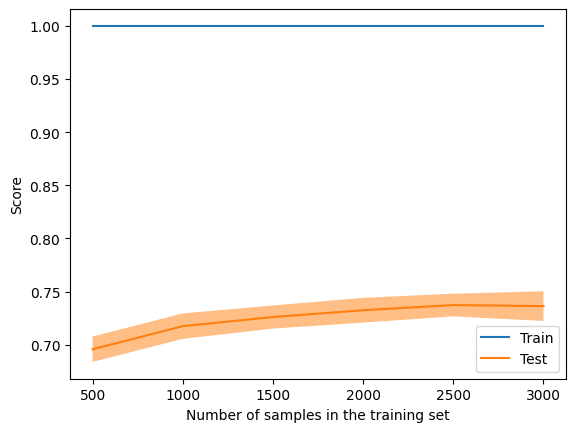

In [12]:
# find best parameters of Random Forest
from lab_tools import find_best_hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}
rf_clf = RandomForestClassifier(random_state=42)
best_params = find_best_hyperparameters(rf_clf,
                                          param_grid,
                                          dataset.train['hog'], 
                                          dataset.train['labels'])
best_rf_model = RandomForestClassifier(**best_params)
ML_pipeline(best_rf_model,
            dataset.train['hog'],
            dataset.train['labels'],
            dataset.test['hog'],
            dataset.test['labels'],
            True)

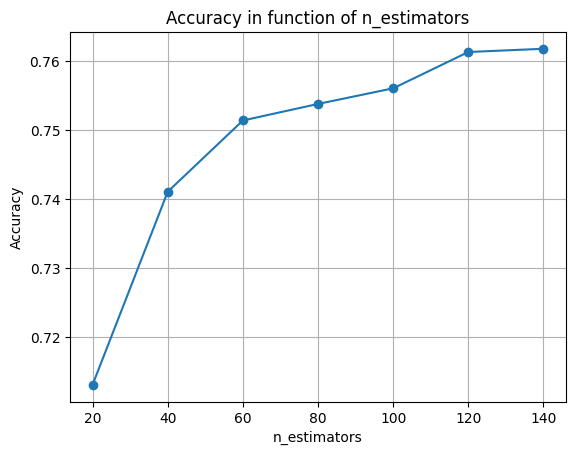

[0.7130666666666666,
 0.7410666666666665,
 0.7514000000000001,
 0.7538,
 0.7560666666666667,
 0.7613333333333332,
 0.7617999999999999]

In [13]:
# extensive search of n_estimators
evaluate_parameter(
    model_class=RandomForestClassifier,
    param_name='n_estimators',
    param_range=range(20, 160, 20),
    X_train=dataset.train['hog'],
    y_train=dataset.train['labels'],
    fixed_params={'max_depth': 15, 'min_samples_split': 2}
)